In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Experiment 1: Variation in Welfare Function

In [2]:
#Initialize Parameters
np.random.seed(0)
L = 448 #num total locations
R = 10  #total security personnel
k = 500 #total fine collected
lambda_vec = [np.random.exponential(80) for i in range(L)] #vector of number of fraudulent users
d_vec = [np.random.exponential(20) for i in range(L)] #vector of benefits from engaging in fraud

#Welfare vectors: v_l = lambda_vec[i] * (d_vec[i])^x for x in {1, 1.25, 1.5, 1.75, 2}
value_vec1 = [lambda_vec[i]*d_vec[i] for i in range(L)] 
value_vec2 = [lambda_vec[i]*(d_vec[i]**1.25) for i in range(L)]
value_vec3 = [lambda_vec[i]*(d_vec[i]**1.5) for i in range(L)]
value_vec4 = [lambda_vec[i]*(d_vec[i]**1.75) for i in range(L)]
value_vec5 = [lambda_vec[i]*(d_vec[i]**2) for i in range(L)]
total_value_vec = [value_vec1, value_vec2, value_vec3, value_vec4, value_vec5]

In [3]:
#Sub-Routine for Step 1 of Contract-Greedy

def func_step1_rev1(R, L, k, alpha_, sorted_value_vec, sorted_d_vec, sorted_lambda_vec, sorted_max_vec, sorted_max_index_vec):

    '''
    Compute the Greedy solution for locations sorted in the descending order of
    z_l values for the algorithm Contract-Greedy
    '''
    
    R_updated = R
    obj_val = 0
    fraud_val = 0
    total_obj = 0
    for i in range(L):
        resource_reqd = sorted_d_vec[i]/(sorted_d_vec[i]+k)

        if resource_reqd <= R_updated:
            R_updated -= resource_reqd
            
            if sorted_max_index_vec[i] == 1:
                obj_val += 0
                fraud_val += sorted_value_vec[i]
                total_obj += obj_val + alpha_ * fraud_val
            else:
                obj_val += resource_reqd * (sorted_lambda_vec[i] * k)
                fraud_val += resource_reqd * (sorted_value_vec[i] )
                total_obj += obj_val + alpha_ * fraud_val

        else:
            obj_val += R_updated * (sorted_lambda_vec[i] * k)
            fraud_val += R_updated * (sorted_value_vec[i])
            total_obj += obj_val + alpha_ * fraud_val

            break
            
    return obj_val, fraud_val, total_obj

In [4]:
#Sub-routine for Step 2 of Contract-Greedy
def func_step2_rev2(R, L, k, alpha_, sorted_max_vec, sorted_max_index_vec, sorted_value_vec, sorted_d_vec, sorted_lambda_vec):
    
    '''
    Compute the allocation that maximizes revenue = Q_R + \alpha * W_R
    from spending at a single location
    '''
    
    #If user best response at threshold is to commit fraud
    if sorted_max_index_vec[0] == 1:
        max_single_rev = 0
        max_single_fraud = np.max(np.array(sorted_value_vec))
        total_obj = max_single_rev + alpha_ * max_single_fraud
        
    else:
        max_single_fraud = sorted_value_vec[0] * sorted_d_vec[0]/(sorted_d_vec[0]+k)
        max_single_rev = sorted_lambda_vec[0] * k * sorted_d_vec[0]/(sorted_d_vec[0]+k)
        total_obj = max_single_rev + alpha_ * max_single_fraud
    
    return max_single_rev, max_single_fraud, total_obj

In [5]:
#Implementation of Contract Greedy

#Discretize set of alpha values with 0.05 increments
alpha_vals = np.linspace(0, 1, 21)

#Initialize vector of revenue and welfare for the different values of alpha for the 5 welfare functions
full_obj_val_arr_rev = np.zeros((5, len(alpha_vals)))
full_obj_val_arr_fraud = np.zeros((5, len(alpha_vals)))

#Iterate over the set of welfare functions and the alpha values to populate the revenue and welfare
for value_vec_idx, value_vec in enumerate(total_value_vec):

    for alpha_idx, alpha_ in enumerate(alpha_vals):

        #Sort the locations in order of z_l
        rev_vec_vals = [ (lambda_vec[i] * k + alpha_ * value_vec[i]) * d_vec[i]/(d_vec[i]+k) for i in range(L) ]
        value_vec_vals = [ alpha_ * value_vec[i] for i in range(L) ]

        # Element-wise maximum
        max_vec = np.maximum(rev_vec_vals, value_vec_vals)

        # Find indices where maximum occurred
        max_index_vec = []
        for i in range(L):
            if rev_vec_vals[i] > value_vec_vals[i]:
                max_index_vec.append(0)
            else:
                max_index_vec.append(1)

        # Combine max_vec and max_index_vec into a list of tuples
        combined_list = [(max_vec[i], max_index_vec[i], value_vec[i], lambda_vec[i], d_vec[i]) for i in range(len(max_vec))]#list(zip(max_vec, max_index_vec))

        # Sort max_vec and max_index_vec based on max_vec (descending order)
        sorted_combined_list = sorted(combined_list, key=lambda x: (k * x[3] + alpha_ * x[2]) if x[1] == 0 else alpha_ * x[2]/((x[4])/(x[4]+k)), reverse=True)

        # Separate the sorted values and indices
        sorted_max_vec = [item[0] for item in sorted_combined_list]
        sorted_max_index_vec = [item[1] for item in sorted_combined_list]
        sorted_value_vec = [item[2] for item in sorted_combined_list]
        sorted_lambda_vec = [item[3] for item in sorted_combined_list]
        sorted_d_vec = [item[4] for item in sorted_combined_list]

        #For the sorted values, call the step 1 and step 2 sub-routines of Contract-Greedy
        obj_val1, fraud_val1, total_obj1 = func_step1_rev1(R, L, k, alpha_, sorted_value_vec, sorted_d_vec, sorted_lambda_vec, sorted_max_vec, sorted_max_index_vec)
        obj_val2, fraud_val2, total_obj2 = func_step2_rev2(R, L, k, alpha_, sorted_max_vec, sorted_max_index_vec, sorted_value_vec, sorted_d_vec, sorted_lambda_vec)
        
        #Select the sub-routine with the highest objective for the administrator
        final_obj_val_ = max(total_obj1, total_obj2)
        if total_obj1 == final_obj_val_:
            final_fraud_val = fraud_val1
            final_rev_val = obj_val1
        else:
            final_fraud_val = fraud_val2
            final_rev_val = obj_val2
            
        #Populate the values of the revenue and welfare
        full_obj_val_arr_rev[value_vec_idx, alpha_idx] = final_rev_val
        full_obj_val_arr_fraud[value_vec_idx, alpha_idx] = final_fraud_val

In [6]:
#Implementation of Algorithm 2 in welfare maximization setting

#Sub-routine for step 1 of Algorithm 2
def func_step1(R, L, k, sorted_d_vec2, sorted_value_vec2, sorted_lambda_vec2):

    '''
    Compute the Greedy solution for locations sorted in the descending order of
    the bang-per-buck ratios for Algorithm 2
    '''
    
    R_updated = R
    obj_val = 0
    rev_val = 0
    for i in range(L):
        resource_reqd = sorted_d_vec2[i]/(sorted_d_vec2[i]+k)

        if resource_reqd <= R_updated:
            R_updated -= resource_reqd
            obj_val += sorted_value_vec2[i]

        else:
            obj_val += R_updated * (sorted_value_vec2[i])
            rev_val += R_updated * (k * sorted_lambda_vec2[i])

            break
            
    return obj_val, rev_val

#Sub-routine for step 2 of Algorithm 2
def func_step2(R, L, k, sorted_d_vec2, sorted_value_vec2, sorted_lambda_vec2):
    
    '''
    Compute the allocation that maximizes welfare = W_R
    from spending at a single location
    '''
    
    max_single_spend = np.max(np.array(sorted_value_vec2))
    rev_val = 0
    return max_single_spend, rev_val


#Initialize welfare and revenue vectors for the 5 different welfare functions
full_obj_val_arr_opt_fraud = np.zeros(5)
full_obj_val_arr_opt_rev = np.zeros(5)

#Implementation of Algorithm 2

for value_vec_idx, value_vec in enumerate(total_value_vec):

    #Sort locations in descending order of bang-per-buck ratios
    
    # Combine
    combined_list2 = [(value_vec[i], d_vec[i], lambda_vec[i]) for i in range(len(value_vec))]

    # Sort 
    sorted_combined_list2 = sorted(combined_list2, key=lambda x: x[0]/((x[1])/(x[1] + k)), reverse=True)

    sorted_value_vec2 = [item[0] for item in sorted_combined_list2]
    sorted_d_vec2 = [item[1] for item in sorted_combined_list2]
    sorted_lambda_vec2 = [item[2] for item in sorted_combined_list2]
        
    #For the sorted values, call the step 1 and step 2 sub-routines of Algorithm 2
    obj_val1, rev_val1 = func_step1(R, L, k, sorted_d_vec2, sorted_value_vec2, sorted_lambda_vec2)
    obj_val2, rev_val2 = func_step2(R, L, k, sorted_d_vec2, sorted_value_vec2, sorted_lambda_vec2)
    
    #Select the sub-routine with the highest objective for the administrator
    final_obj_val = max(obj_val1, obj_val2)
    if final_obj_val == obj_val1:
        final_rev_val = rev_val1
    else:
        final_rev_val = rev_val2
    
    #Populate the values of the revenue and welfare
    full_obj_val_arr_opt_fraud[value_vec_idx] = final_obj_val
    full_obj_val_arr_opt_rev[value_vec_idx] = final_rev_val

Text(0, 0.5, 'Proportion of Optimal Social Welfare')

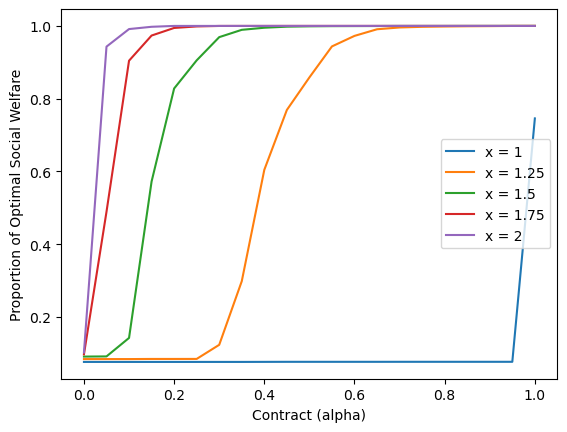

In [9]:
#Plot the ratio of the welfare corresponding to contract greedy to that of Algorithm 2 for different welfare functions
plt.plot(alpha_vals, [full_obj_val_arr_fraud[0, i]/full_obj_val_arr_opt_fraud[0] for i in range(len(alpha_vals))])
plt.plot(alpha_vals, [full_obj_val_arr_fraud[1, i]/full_obj_val_arr_opt_fraud[1] for i in range(len(alpha_vals))])
plt.plot(alpha_vals, [full_obj_val_arr_fraud[2, i]/full_obj_val_arr_opt_fraud[2] for i in range(len(alpha_vals))])
plt.plot(alpha_vals, [full_obj_val_arr_fraud[3, i]/full_obj_val_arr_opt_fraud[3] for i in range(len(alpha_vals))])
plt.plot(alpha_vals, [full_obj_val_arr_fraud[4, i]/full_obj_val_arr_opt_fraud[4] for i in range(len(alpha_vals))])

plt.legend(['x = 1', 'x = 1.25', 'x = 1.5', 'x = 1.75', 'x = 2'])
plt.xlabel('Contract (alpha)')
plt.ylabel('Proportion of Optimal Social Welfare')

# Experiments 2 & 2: Vary Number of Resources and Fines

In [11]:
#Initialize Parameters
np.random.seed(0)
L = 448 #num total locations
lambda_vec = [np.random.exponential(80) for i in range(L)] #Vector of number of fraudulent users
d_vec = [np.random.exponential(20) for i in range(L)] #Benefits vector
value_vec = [lambda_vec[i]*(d_vec[i]**1.25) for i in range(L)] #Welfare vector

In [12]:
#Contract Greedy Implementation

#Initialize set of alpha values
alpha_vals = np.linspace(0, 1, 21)

#Vector of number of resources and fines
R_values = np.linspace(1, 30, 30)
k_values = np.linspace(50, 500, 10)

#Initialize vector of revenue and welfare for the different values of R, k, alpha
full_obj_val_arr_rev = np.zeros((len(R_values), len(k_values), len(alpha_vals)))
full_obj_val_arr_fraud = np.zeros((len(R_values), len(k_values), len(alpha_vals)))

#Iterate over the set of R, k, alpha to populate the revenue and welfare
for alpha_idx, alpha_ in enumerate(alpha_vals):

    for R_idx, R in enumerate(R_values):
        for k_idx, k in enumerate(k_values):
            
            #Sort the locations in order of z_l
            rev_vec_vals = [ (lambda_vec[i] * k + alpha_ * value_vec[i]) * d_vec[i]/(d_vec[i]+k) for i in range(L) ]
            value_vec_vals = [ alpha_ * value_vec[i] for i in range(L) ]

            # Element-wise maximum
            max_vec = np.maximum(rev_vec_vals, value_vec_vals)

            # Find indices where maximum occurred
            max_index_vec = []
            for i in range(L):
                if rev_vec_vals[i] > value_vec_vals[i]:
                    max_index_vec.append(0)
                else:
                    max_index_vec.append(1)

            # Combine max_vec and max_index_vec into a list of tuples
            combined_list = [(max_vec[i], max_index_vec[i], value_vec[i], lambda_vec[i], d_vec[i]) for i in range(len(max_vec))]#list(zip(max_vec, max_index_vec))

            # Sort max_vec and max_index_vec based on max_vec (descending order)
            sorted_combined_list = sorted(combined_list, key=lambda x: (k * x[3] + alpha_ * x[2]) if x[1] == 0 else alpha_ * x[2]/((x[4])/(x[4]+k)), reverse=True)

            # Separate the sorted values and indices
            sorted_max_vec = [item[0] for item in sorted_combined_list]
            sorted_max_index_vec = [item[1] for item in sorted_combined_list]
            sorted_value_vec = [item[2] for item in sorted_combined_list]
            sorted_lambda_vec = [item[3] for item in sorted_combined_list]
            sorted_d_vec = [item[4] for item in sorted_combined_list]
            
            #For the sorted values, call the step 1 and step 2 sub-routines of Contract-Greedy
            obj_val1, fraud_val1, total_obj1 = func_step1_rev1(R, L, k, alpha_, sorted_value_vec, sorted_d_vec, sorted_lambda_vec, sorted_max_vec, sorted_max_index_vec)
            obj_val2, fraud_val2, total_obj2 = func_step2_rev2(R, L, k, alpha_, sorted_max_vec, sorted_max_index_vec, sorted_value_vec, sorted_d_vec, sorted_lambda_vec)
            
            #Select the sub-routine with the highest objective for the administrator
            final_obj_val_ = max(total_obj1, total_obj2)
            if total_obj1 == final_obj_val_:
                final_fraud_val = fraud_val1
                final_rev_val = obj_val1
            else:
                final_fraud_val = fraud_val2
                final_rev_val = obj_val2
                
            #Populate the values of the revenue and welfare
            full_obj_val_arr_rev[R_idx, k_idx, alpha_idx] = final_rev_val
            full_obj_val_arr_fraud[R_idx, k_idx, alpha_idx] = final_fraud_val

In [13]:
#Implementation of Algorithm 2 in Welfare Maximization setting

#Vector of number of resources and fines
R_values = np.linspace(1, 30, 30)
k_values = np.linspace(50, 500, 10)

#Initialize vector of revenue and welfare for the different values of R, k
full_obj_val_arr_opt_fraud = np.zeros((len(R_values), len(k_values)))
full_obj_val_arr_opt_rev = np.zeros((len(R_values), len(k_values)))

#Iterate over the set of R, k to populate the revenue and welfare
for k_idx, k in enumerate(k_values):

    #Sort the locations in order of bang-per-buck ratios
    # Combine
    combined_list2 = [(value_vec[i], d_vec[i], lambda_vec[i]) for i in range(len(value_vec))]

    # Sort 
    sorted_combined_list2 = sorted(combined_list2, key=lambda x: x[0]/((x[1])/(x[1] + k)), reverse=True)

    sorted_value_vec2 = [item[0] for item in sorted_combined_list2]
    sorted_d_vec2 = [item[1] for item in sorted_combined_list2]
    sorted_lambda_vec2 = [item[2] for item in sorted_combined_list2]
    
    for R_idx, R in enumerate(R_values):
        
        #For the sorted values, call the step 1 and step 2 sub-routines of Algorithm 2
        obj_val1, rev_val1 = func_step1(R, L, k, sorted_d_vec2, sorted_value_vec2, sorted_lambda_vec2)
        obj_val2, rev_val2 = func_step2(R, L, k, sorted_d_vec2, sorted_value_vec2, sorted_lambda_vec2)
        
        #Select the sub-routine with the highest objective for the administrator
        final_obj_val = max(obj_val1, obj_val2)
        if final_obj_val == obj_val1:
            final_rev_val = rev_val1
        else:
            final_rev_val = rev_val2
            
        #Populate the values of the revenue and welfare
        full_obj_val_arr_opt_fraud[R_idx, k_idx] = final_obj_val
        full_obj_val_arr_opt_rev[R_idx, k_idx] = final_rev_val

Text(0, 0.5, 'Proportion of Optimal Social Welfare')

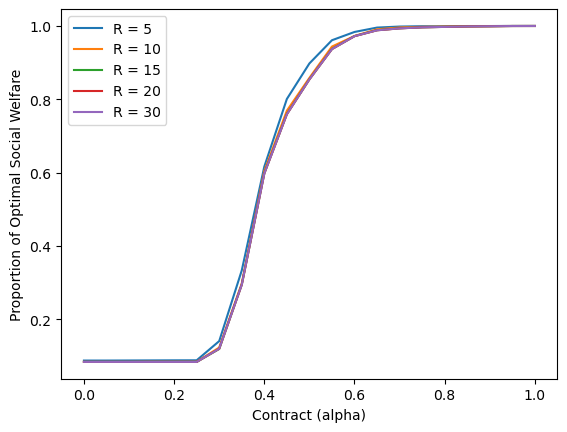

In [14]:
#Plot the ratio of the welfare corresponding to contract greedy to that of Algorithm 2 
#for different welfare functions with k = 500
plt.plot(alpha_vals, [full_obj_val_arr_fraud[4, -1, i]/full_obj_val_arr_opt_fraud[4, -1] for i in range(len(alpha_vals))])
plt.plot(alpha_vals, [full_obj_val_arr_fraud[9, -1, i]/full_obj_val_arr_opt_fraud[9, -1] for i in range(len(alpha_vals))])
plt.plot(alpha_vals, [full_obj_val_arr_fraud[14, -1, i]/full_obj_val_arr_opt_fraud[14, -1] for i in range(len(alpha_vals))])
plt.plot(alpha_vals, [full_obj_val_arr_fraud[19, -1, i]/full_obj_val_arr_opt_fraud[19, -1] for i in range(len(alpha_vals))])
plt.plot(alpha_vals, [full_obj_val_arr_fraud[29, -1, i]/full_obj_val_arr_opt_fraud[29, -1] for i in range(len(alpha_vals))])

plt.legend(['R = 5', 'R = 10', 'R = 15', 'R = 20', 'R = 30'])
plt.xlabel('Contract (alpha)')
plt.ylabel('Proportion of Optimal Social Welfare')

Text(0, 0.5, 'Proportion of Optimal Social Welfare')

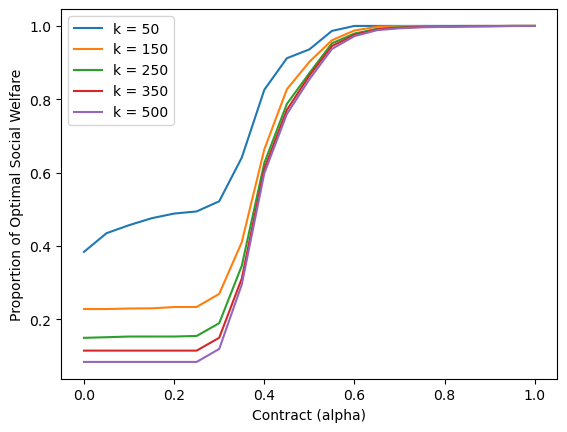

In [15]:
#Plot the ratio of the welfare corresponding to contract greedy to that of Algorithm 2 
#for different welfare functions with R = 15
plt.plot(alpha_vals, [full_obj_val_arr_fraud[14, 0, i]/full_obj_val_arr_opt_fraud[14, 0] for i in range(len(alpha_vals))])
plt.plot(alpha_vals, [full_obj_val_arr_fraud[14, 2, i]/full_obj_val_arr_opt_fraud[14, 2] for i in range(len(alpha_vals))])
plt.plot(alpha_vals, [full_obj_val_arr_fraud[14, 4, i]/full_obj_val_arr_opt_fraud[14, 4] for i in range(len(alpha_vals))])
plt.plot(alpha_vals, [full_obj_val_arr_fraud[14, 6, i]/full_obj_val_arr_opt_fraud[14, 6] for i in range(len(alpha_vals))])
plt.plot(alpha_vals, [full_obj_val_arr_fraud[14, 9, i]/full_obj_val_arr_opt_fraud[14, 9] for i in range(len(alpha_vals))])

plt.legend(['k = 50', 'k = 150', 'k = 250', 'k = 350', 'k = 500'])
plt.xlabel('Contract (alpha)')
plt.ylabel('Proportion of Optimal Social Welfare')

# Appendix Experiments I: Welfare vs. Revenue with Varying Resources

In [16]:
#Initialize Parameters
np.random.seed(0)
L = 448 #num locations
R_values = np.linspace(1, 30, 30) #Total security resources
k = 500 #fine
lambda_vec = [np.random.exponential(80) for i in range(L)] #Vector of number of fraudulent users
d_vec = [np.random.exponential(20) for i in range(L)] #Benefits vector
value_vec = [lambda_vec[i]*(d_vec[i]**1.25) for i in range(L)] #Welfare vector

In [19]:
#Implementation of Algorithm 2 in Welfare Maximization setting

#Initialize vector of revenue and welfare for the different values of R
full_obj_val_arr_opt_fraud = np.zeros(len(R_values))
full_obj_val_arr_opt_rev = np.zeros(len(R_values))

#Sort the locations in order of bang-per-buck ratios
# Combine
combined_list2 = [(value_vec[i], d_vec[i], lambda_vec[i]) for i in range(len(value_vec))]

# Sort 
sorted_combined_list2 = sorted(combined_list2, key=lambda x: x[0]/((x[1])/(x[1] + k)), reverse=True)

sorted_value_vec2 = [item[0] for item in sorted_combined_list2]
sorted_d_vec2 = [item[1] for item in sorted_combined_list2]
sorted_lambda_vec2 = [item[2] for item in sorted_combined_list2]

#Iterate over all resource values
for R_idx, R in enumerate(R_values):

    #For the sorted values, call the step 1 and step 2 sub-routines of Algorithm 2
    obj_val1, rev_val1 = func_step1(R, L, k, sorted_d_vec2, sorted_value_vec2, sorted_lambda_vec2)
    obj_val2, rev_val2 = func_step2(R, L, k, sorted_d_vec2, sorted_value_vec2, sorted_lambda_vec2)
    
    #Select the sub-routine with the highest objective for the administrator
    final_obj_val = max(obj_val1, obj_val2)
    if final_obj_val == obj_val1:
        final_rev_val = rev_val1
    else:
        final_rev_val = rev_val2
        
    #Populate the values of the revenue and welfare
    full_obj_val_arr_opt_fraud[R_idx] = final_obj_val
    full_obj_val_arr_opt_rev[R_idx] = final_rev_val

In [20]:
#Implementation of Algorithm 1 in Revenue Maximization Setting

#Order locations in descending order of Lambda_l values
sorted_values = sorted(zip(lambda_vec, d_vec, value_vec), key=lambda x: x[0] , reverse=True)
sorted_lambda_vec_rev, sorted_d_vec_rev, sorted_value_vec_rev = zip(*sorted_values)

#Implementation of sub-routine of Algorithm 1
def func_step1_rev(R, L, k, sorted_d_vec_rev, sorted_lambda_vec_rev, sorted_value_vec_rev):

    '''
    Compute the Greedy solution for locations sorted in the descending order of
    Lambda_l values for algorithm 1
    '''
    
    R_updated = R
    obj_val = 0
    fraud_val = 0
    for i in range(L):
        resource_reqd = sorted_d_vec_rev[i]/(sorted_d_vec_rev[i]+k)

        if resource_reqd <= R_updated:
            R_updated -= resource_reqd
            obj_val += resource_reqd * (sorted_lambda_vec_rev[i] * k)
            fraud_val += resource_reqd * (sorted_value_vec_rev[i] )

        else:
            obj_val += R_updated * (sorted_lambda_vec_rev[i] * k)
            fraud_val += R_updated * (sorted_value_vec_rev[i])

            break
            
    return obj_val, fraud_val
    
    max_single_fraud = sorted_value_vec_rev[max_index_spend] * (sorted_d_vec_rev[max_index_spend]/(sorted_d_vec_rev[max_index_spend]+k)) 
    
    return max_single_spend, max_single_fraud

#Initialize vector of revenue and welfare for the different values of R
rev_full_obj_val_arr_rev = np.zeros(len(R_values))
rev_full_obj_val_arr_fraud = np.zeros(len(R_values))

#Iterate over all resource values
for R_idx, R in enumerate(R_values):
    
    #For the sorted values, call the sub-routine of Algorithm 1
    obj_val1, fraud_val1 = func_step1_rev(R, L, k, sorted_d_vec_rev, sorted_lambda_vec_rev, sorted_value_vec_rev)
    
    #Populate the values of the revenue and welfare
    rev_full_obj_val_arr_rev[R_idx] = obj_val1
    rev_full_obj_val_arr_fraud[R_idx] = fraud_val1

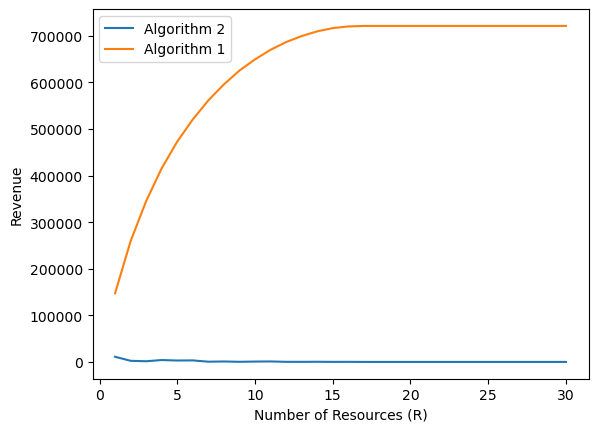

In [21]:
#Plot the revenue corresponding to the solutions of Algorithms 1 and 2
plt.plot(R_values, full_obj_val_arr_opt_rev.T)
plt.plot(R_values, rev_full_obj_val_arr_rev.T)

# Set labels and title
plt.xlabel('Number of Resources (R)')
plt.ylabel('Revenue')

plt.legend(['Algorithm 2', 'Algorithm 1'])


# Show the plot
plt.show()

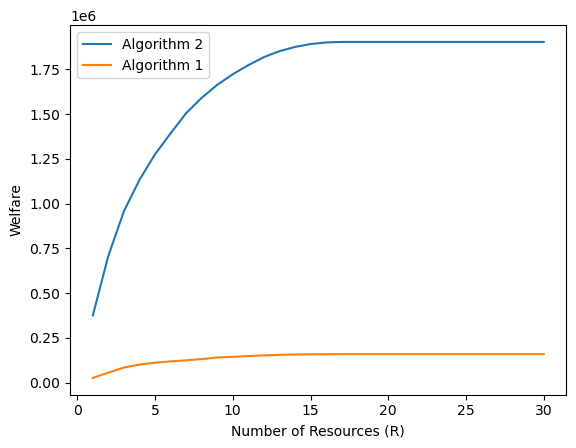

In [22]:
#Plot the welfare corresponding to the solutions of Algorithms 1 and 2
plt.plot(R_values, full_obj_val_arr_opt_fraud.T)
plt.plot(R_values, rev_full_obj_val_arr_fraud.T)

# Set labels and title
plt.xlabel('Number of Resources (R)')
plt.ylabel('Welfare')

plt.legend(['Algorithm 2', 'Algorithm 1'])

# Show the plot
plt.show()

# Appendix Experiments II: Welfare vs. Revenue with Varying Fines

In [23]:
#Initialize Parameters
np.random.seed(0)
L = 448 #num locations
R = 15 #Total security resources
k_values = np.linspace(50, 500, 10) #ranges of values of fines
lambda_vec = [np.random.exponential(80) for i in range(L)] #Vector of number of fraudulent users
d_vec = [np.random.exponential(20) for i in range(L)] #Benefits vector
value_vec = [lambda_vec[i]*(d_vec[i]**1.25) for i in range(L)] #Welfare vector

In [24]:
#Implementation of Algorithm 2 in Welfare Maximization setting

#Initialize vector of revenue and welfare for the different values of k
full_obj_val_arr_opt_fraud = np.zeros(len(k_values))
full_obj_val_arr_opt_rev = np.zeros(len(k_values))

#Iterate of fine values
for k_idx, k in enumerate(k_values):

    #Sort locations in descending order of bang-per-buck ratios
    # Combine
    combined_list2 = [(value_vec[i], d_vec[i], lambda_vec[i]) for i in range(len(value_vec))]

    # Sort 
    sorted_combined_list2 = sorted(combined_list2, key=lambda x: x[0]/((x[1])/(x[1] + k)), reverse=True)

    sorted_value_vec2 = [item[0] for item in sorted_combined_list2]
    sorted_d_vec2 = [item[1] for item in sorted_combined_list2]
    sorted_lambda_vec2 = [item[2] for item in sorted_combined_list2]
    
    #For the sorted values, call the step 1 and step 2 sub-routines of Algorithm 2
    obj_val1, rev_val1 = func_step1(R, L, k, sorted_d_vec2, sorted_value_vec2, sorted_lambda_vec2)
    obj_val2, rev_val2 = func_step2(R, L, k, sorted_d_vec2, sorted_value_vec2, sorted_lambda_vec2)
    
    #Select the sub-routine with the highest objective for the administrator
    final_obj_val = max(obj_val1, obj_val2)
    if final_obj_val == obj_val1:
        final_rev_val = rev_val1
    else:
        final_rev_val = rev_val2
        
    #Populate the values of the revenue and welfare
    full_obj_val_arr_opt_fraud[k_idx] = final_obj_val
    full_obj_val_arr_opt_rev[k_idx] = final_rev_val

In [25]:
#Implementation of Algorithm 1 in Revenue Maximization Setting

#Initialize vector of revenue and welfare for the different values of k
rev_full_obj_val_arr_rev = np.zeros(len(k_values))
rev_full_obj_val_arr_fraud = np.zeros(len(k_values))

#Iterate over all fine values
for k_idx, k in enumerate(k_values):

    #Order locations in descending order of Lambda_l values
    sorted_values = sorted(zip(lambda_vec, d_vec, value_vec), key=lambda x: x[0] , reverse=True)
    sorted_lambda_vec_rev, sorted_d_vec_rev, sorted_value_vec_rev = zip(*sorted_values)

    #For the sorted values, call the sub-routine of Algorithm 1
    obj_val1, fraud_val1 = func_step1_rev(R, L, k, sorted_d_vec_rev, sorted_lambda_vec_rev, sorted_value_vec_rev)
    
    #Populate the values of the revenue and welfare
    rev_full_obj_val_arr_rev[k_idx] = obj_val1
    rev_full_obj_val_arr_fraud[k_idx] = fraud_val1

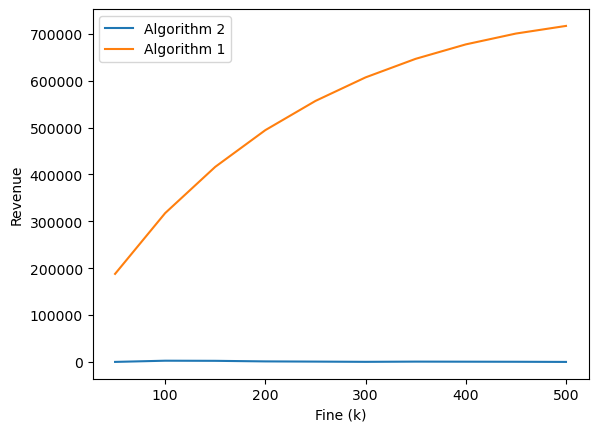

In [26]:
#Plot the revenue corresponding to the solutions of Algorithms 1 and 2
plt.plot(k_values, full_obj_val_arr_opt_rev.T)
plt.plot(k_values, rev_full_obj_val_arr_rev.T)

# Set labels and title
plt.xlabel('Fine (k)')
plt.ylabel('Revenue')

plt.legend(['Algorithm 2', 'Algorithm 1'])

# Show the plot
plt.show()

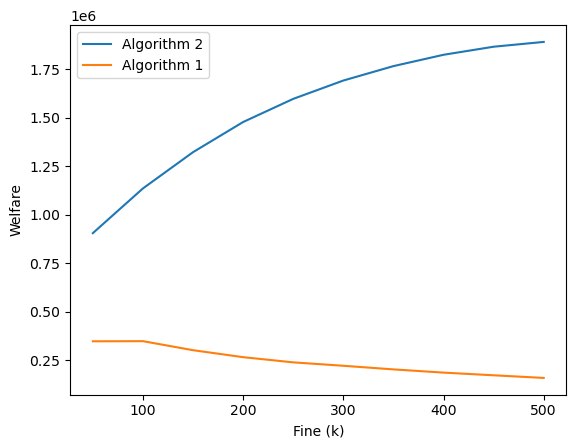

In [27]:
#Plot the welfare corresponding to the solutions of Algorithms 1 and 2
plt.plot(k_values, full_obj_val_arr_opt_fraud.T)
plt.plot(k_values, rev_full_obj_val_arr_fraud.T)

# Set labels and title
plt.xlabel('Fine (k)')
plt.ylabel('Welfare')

plt.legend(['Algorithm 2', 'Algorithm 1'])

# Show the plot
plt.show()